# Предсказание рейтинга отелей

## Описание проекта
Одна из проблем компании Booking — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.
Есть датасет, в котором содержатся сведения о 515 000 отзывов на отели Европы. Модель должна предсказывать рейтинг отеля по данным сайта Booking на основе имеющихся в датасете данных.
Описание столбов в датасете:
* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой очистки;
* additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

In [66]:
# импорт необходимых библиотек
import pandas as pd
import category_encoders as ce
from geopy.geocoders import Nominatim
import time
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Ознакомление с данными

In [67]:
# откроем заруженные с Kaggle датасеты для соревнования
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для тестирования

In [68]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotels = pd.concat([df_test, df_train], sort=False).reset_index(drop=True) # объединяем

In [69]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

In [70]:
hotels.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0


17 признаков, 8 типа 'object и 9 числовых признаков. Предсказывать будем reviewer_score. Есть пропущенные значения в столбцах 'lat' и 'lng'.

## Ответы на вопросы юнита 4
Ответим на вопросы юнита 4. Оценку значимости признаков я планирую привести позже, после того, как переведу все категориальные признаки в числовые.

### Количество уникальных названий отелей

In [71]:
print('Количество уникальных отелей равно', hotels['hotel_name'].nunique())

Количество уникальных отелей равно 1492


### Когда оставлен самый старый и самый свежий отзыв

In [72]:
# переведем признак с датой в формат datetime
hotels['review_date'] = pd.to_datetime(hotels['review_date'])
print('Самый свежий отзыв был оставлен:', hotels['review_date'].min())
print('Самый старый отзыв был оставлен:', hotels['review_date'].max())

Самый свежий отзыв был оставлен: 2015-08-04 00:00:00
Самый старый отзыв был оставлен: 2017-08-03 00:00:00


### Количество уникальных тегов

In [73]:
# Преобразуем столбец с тегами в столбец со списоком тегов:
def tags_to_list(tag): # функция для преобразования строки с тегами в список тегов:
    tag = tag[2:-2] # уберем лишние символы в начале и конце тегов
    res = tag.strip().split(' \', \' ') # уберем пробелы с начала и конца строки, разделим на теги по символам " ', ' "
    return res
# применим функцию к столбцу с тегами
hotels['tags_new'] = hotels['tags'].apply(tags_to_list)
# подсчитаем уникальные тэги:
print('Количество уникальных тэгов равно', len(hotels['tags_new'].explode().unique()))

Количество уникальных тэгов равно 2428


### Наиболее часто встречающийся тег

In [74]:
print('Чаще всего встречается тег', hotels['tags_new'].explode().value_counts().index[0])

Чаще всего встречается тег Leisure trip


### На сколько ночей чаще всего останавливались путешественники
Заодно тут создадим новый признак количество ночей 'nights'

In [75]:
# функция для выявления количества ночей из тегов:
def nights_count(list):
    for i in range(0, len(list)):
        if 'Stayed' in list[i]: # если в теге встречается слово Stayed, то берем из него количество ночей, которое идет после Stayed
            return int(list[i][7:9].replace(' ',''))

hotels['nights'] = hotels['tags_new'].apply(nights_count)
print('Чаще всего путешественники останавливались на', hotels['nights'].value_counts().index[0], 'ночь')

Чаще всего путешественники останавливались на 1.0 ночь


Также проверим, есть ли в новом столбце пропуски:

In [76]:
hotels['nights'].isna().sum()

192

146 пропусков. Заполним их наиболее часто встречающимся значением - 1.

In [77]:
hotels['nights'] = hotels['nights'].fillna(value = '1')
hotels['nights'].describe()

count     515738.0
unique        32.0
top            1.0
freq      193645.0
Name: nights, dtype: float64

## Удаление строковых данных

### Признак 'hotel_country'.

Начнем по порядку с признака hotel_address. Из него можно найти страну отеля.

In [78]:
# Найдем страну отеля
hotels['hotel_country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.split(' ')[-1] == 'Kingdom' else x.split(' ')[-1])
hotels['hotel_country'].value_counts()

United Kingdom    262301
Spain              60149
France             59928
Netherlands        57214
Austria            38939
Italy              37207
Name: hotel_country, dtype: int64

In [79]:
# преобразуем признак, закодируем его, используя однократное кодирование
encoder = ce.OneHotEncoder(cols=['hotel_country'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['hotel_country'])
hotels = pd.concat([hotels, type_bin], axis=1)

Посмотрим признак "reviewer_nationality"

In [80]:
hotels['reviewer_nationality'].value_counts().head(30)


 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
 Singapore                      3091
 Hong Kong                      3013
 

In [81]:
popular_nationality = hotels['reviewer_nationality'].value_counts().nlargest(30).index

In [82]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].apply(lambda x: x if x in popular_nationality else 'other')
hotels['reviewer_nationality'].value_counts()

 United Kingdom               245246
other                          61634
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
 Saudi Arabia                   8951
 Netherlands                    8772
 Switzerland                    8678
 Germany                        7941
 Canada                         7894
 France                         7296
 Israel                         6610
 Italy                          6114
 Belgium                        6031
 Turkey                         5444
 Kuwait                         4920
 Spain                          4737
 Romania                        4552
 Russia                         3900
 South Africa                   3821
 India                          3437
 Greece                         3406
 China                          3400
 Sweden                         3368
 New Zealand                    3237
 Singapore                      3091
 

Закодируем признак национальность ревьюера с помощью двоичного кодирования, так как уникальных значений в признаке больше 15.

In [83]:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

Рассмотрим признак "review_date". Можно создать из него новые признаки: год оставления отзыва и месяц оставления отзыва.

In [84]:
hotels['review_year'] = hotels['review_date'].dt.year
hotels['review_year'].unique()

array([2017, 2016, 2015], dtype=int64)

In [85]:
hotels['review_month'] = hotels['review_date'].dt.month
hotels['review_month'].unique()

array([ 7, 12, 11, 10,  5,  8,  6,  9,  1,  3,  4,  2], dtype=int64)

### Признак 'days_since_review' 

Представлен в нашем датасете типом object. Преобразуем его в числовой тип:

In [86]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int(x.split()[0]))
hotels['days_since_review'].describe()

count    515738.000000
mean        354.441932
std         208.928124
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

## Очистка от пропущенных значений

Пропущенные значения у нас есть только в столбцах с координатами 'lat' и 'lng'.
Посмотрим, у скольких отелей пропущены эти значения:

In [87]:
# создадим датафрейм, где будут строки с пропущенными значениями долготы и широты.
without_coord = hotels[hotels['lat'].isnull()]
# посмотрим, сколько отелей в получившемся датафрейме
len(without_coord['hotel_name'].value_counts())

17

In [88]:
without_coord['hotel_address'].unique()

array(['W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria',
       'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria',
       '23 Rue Damr mont 18th arr 75018 Paris France',
       'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria',
       'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria',
       'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria',
       'Bail n 4 6 Eixample 08010 Barcelona Spain',
       'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria',
       '4 rue de la P pini re 8th arr 75008 Paris France',
       '20 Rue De La Ga t 14th arr 75014 Paris France',
       'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria',
       'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria',
       'Pau Clar s 122 Eixample 08009 Barcelona Spain',
       'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria',
       'Paragonstra e 1 11 Simmering 1110 Vienna Austria',
       'Hasenauerstra e 12 19 D bling 1190 Vienna Austria',
       'Sep lveda 180 Eix

Всего 17 отелей с пропущенными координатами. Можно получить координаты вручную. Можно воспользоваться специальными библиотеками для получения координат по адресу, например geopy. Однако при попытке воспользоваться библиотекой оказалось, что адреса записаны некорректно. Например, "Savoyenstra e 2 16 Ottakring 1160 Vienna Austria", а на самом деле "Savoyenstrasse 2, Vienna 1160 Austria". Возможно поэтому и отсутсвуют координаты. Я решила, что адресов не так много и можно вручную заполнить все 17 координат

In [90]:
app = Nominatim(user_agent="tutorial")
# словарь адресов для получения координат. Ключи - адрес некорректный из таблицы, значения - адрес скорректированный вручную.
address_to_get_coord = {'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria':'Savoyenstrasse 2 16 Ottakring, 1160, Vienna, Austria',
                        '23 Rue Damr mont 18th arr 75018 Paris France':'23 rue Damremont 75018 Paris France',
                        'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria':'Josefstadter Strasse 10-12 A-1080 Vienna, Austria',
                        'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria':'Waehringer Strasse 12 1090 Vienna Austria',
                        '4 rue de la P pini re 8th arr 75008 Paris France':'4 rue de la Pepiniere, 75008 Paris France',
                        'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria':'Sieveringer Strasse 4 1190 Vienna Austria',
                        'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria':'Taborstrasse 8 A 02 Leopoldstadt 1020 Vienna Austria',
                        'Bail n 4 6 Eixample 08010 Barcelona Spain':'Bailen 4-6 Eixample 08010 Barcelona Spain',
                        'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria':'Grunentorgasse 30 09 Alsergrund 1090 Vienna Austria',
                        'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria':'Landstrasser Gurtel 5 03 Landstrasse 1030 Vienna Austria',
                        'Paragonstra e 1 11 Simmering 1110 Vienna Austria':'Paragonstrasse 1 11 Simmering 1110 Vienna Austria',
                        'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria':'Wahringer Strasse 33 1090 Vienna Austria',
                        '20 Rue De La Ga t 14th arr 75014 Paris France': '20 Rue De La Gaite 75014 Paris France',
                        'Hasenauerstra e 12 19 D bling 1190 Vienna Austria':'Hasenauerstrasse 12 1190 Vienna Austria',
                        'Sep lveda 180 Eixample 08011 Barcelona Spain':'Sepulveda 180 Eixample 08011 Barcelona Spain',
                        'Pau Clar s 122 Eixample 08009 Barcelona Spain':'Pau Claris 122 Eixample 08009 Barcelona Spain',
                        'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria':'Josefstadter Strasse 22 08 Josefstadt 1080 Vienna Austria'}

# словарь координат для заполнения

coordinates = {}

for elem in address_to_get_coord:
    #try:
        location = app.geocode(address_to_get_coord[elem]).raw
        coordinates[elem] = ([location["lat"], location["lon"]])
    #except GeocoderUnavailable: # на всякий случай проверяла на ошибки, мало ли адрес не пробьется
        #print(elem)
    
coordinates   

{'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': ['48.2159099',
  '16.2780017'],
 '23 Rue Damr mont 18th arr 75018 Paris France': ['48.8888806', '2.3331948'],
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': ['48.2106577',
  '16.3436493'],
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': ['48.216813',
  '16.3599356'],
 '4 rue de la P pini re 8th arr 75008 Paris France': ['48.875248',
  '2.3233746'],
 'Sieveringer Stra e 4 19 D bling 1190 Vienna Austria': ['48.250954',
  '16.325100636510385'],
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': ['48.2172136',
  '16.3808074'],
 'Bail n 4 6 Eixample 08010 Barcelona Spain': ['41.3927215', '2.1760747'],
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': ['48.2208701',
  '16.3638771'],
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': ['48.1881916',
  '16.389577'],
 'Paragonstra e 1 11 Simmering 1110 Vienna Austria': ['48.1861187',
  '16.419982'],
 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienn

In [91]:
def fill_coord(row, dict):
    if pd.isna(row.lat):
        for i in dict.keys():
           if row.hotel_address == i:
               row.lat = dict[i][0]
               row.lng = dict[i][1]    
    return row

hotels_1 = hotels.copy()
hotels = hotels.apply(lambda row: fill_coord(row, coordinates), axis=1 )
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
tags_new                                      0
nights                                        0
hotel_country                           

## Создание новых признаков

### Признак 'distance'


Создадим признак 'distance' - расстояние от отеля до центра города

In [92]:
# создадим столбец с координатами (с широтой и долготой в одном столбце)
hotels['coord'] = list(zip(hotels['lat'],hotels['lng']))

In [93]:
# список городов
hotels['hotel_city'] = hotels['hotel_address'].apply(lambda x: x.split(' ')[-2])
cities = list(hotels['hotel_city'].unique()) 

In [94]:
# получим список кортежей с координатами центров городов из библиотеки geopy
coord_center = [] 

for i in cities:
    try:
        location = app.geocode(i).raw
        coord_center.append((location["lat"], location["lon"]))
    except GeocoderUnavailable:
            print(i)
        
# создадим отдельный датафрейм с координатами центров городов       
df_center = pd.DataFrame({'hotel_city':cities,
                  'coord_center':coord_center})

In [95]:
df_center

,hotel_city,coord_center
0,Milan,"(45.4641943, 9.1896346)"
1,Amsterdam,"(52.3730796, 4.8924534)"
2,Barcelona,"(41.3828939, 2.1774322)"
3,United,"(40.2184039, -79.4878157)"
4,Paris,"(48.8588897, 2.3200410217200766)"
5,Vienna,"(48.2083537, 16.3725042)"


In [96]:
# добавим координаты центров городов в наш датасет:
hotels = hotels.merge(df_center, on = 'hotel_city', how = 'left')

In [97]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

In [98]:
from geopy.distance import geodesic as GD 

In [99]:
# функция для получения расстояния между отелем и центром города
def get_distance(row):
    hotel_coord = row.coord
    center_coord = row.coord_center
    return round(GD(hotel_coord, center_coord).km, 1) 
# применим функцию get_distance к датасету:
hotels['distance'] = hotels.apply(lambda row: get_distance(row), axis = 1)

In [100]:
hotels['distance'].describe()

count    515738.000000
mean       3041.181778
std        2987.143362
min           0.000000
25%           1.900000
50%        5966.200000
75%        5977.300000
max        5989.000000
Name: distance, dtype: float64

### Признак 'ratio_words'

Создадим признак пропорции количества слов из позитивных отзывов к количеству слов в негативных отзывах. Я читер, видела в чате проекта, что количество слов подсчитано в исходном датасете не совсем верно... Поэтому перезапишу на всякий случай столбцы с количеством слов в позитивных и негативных отзывах.

In [101]:
hotels['review_total_negative_word_counts'] = hotels['negative_review'].apply(lambda x: len(x.split(' ')))
hotels['review_total_positive_word_counts'] = hotels['positive_review'].apply(lambda x: len(x.split(' ')))

In [102]:
hotels['ratio_words'] = hotels['review_total_negative_word_counts'] / hotels['review_total_positive_word_counts']
hotels['ratio_words'].describe()

count    515738.000000
mean          2.672860
std           6.688737
min           0.005208
25%           0.250000
50%           0.866667
75%           2.363636
max         201.000000
Name: ratio_words, dtype: float64

### Признак 'citizen'

Создадим признак, в котором будет '1', если страна ревьюера совпадает со страной отеля и '0', если нет.


In [103]:
hotels['citizen'] = hotels.apply((lambda row: 1 if row.hotel_country == row.reviewer_nationality.strip() else 0), axis = 1)
hotels['citizen'].value_counts()

0    337335
1    178403
Name: citizen, dtype: int64

### Признак 'tags_count'

Создадим признак количество тегов для каждого отзыва

In [104]:
hotels['tags_count'] = hotels['tags_new'].apply(lambda x: len(x))
hotels['tags_count'].describe()

count    515738.000000
mean          4.569359
std           0.520187
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           6.000000
Name: tags_count, dtype: float64

### Признак 'type_trip'

Создадим признак 'type_trip', чтобы понять, была ли поездка деловой или для отдыха

In [105]:
def get_trip(x):
    if x[0] == 'Leisure trip' or x[0] == 'Business trip':
        return x[0]
    else:
        return 'unknown'
hotels['type_trip'] = hotels['tags_new'].apply(get_trip)
hotels['type_trip'].value_counts()

Leisure trip     416672
Business trip     82748
unknown           16318
Name: type_trip, dtype: int64

In [106]:
# преобразуем признак, закодируем его, используя однократное кодирование
encoder = ce.OneHotEncoder(cols=['type_trip'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['type_trip'])
hotels = pd.concat([hotels, type_bin], axis=1)

## Преобразование признаков

Для преобразования признаков 'positive_review' и 'negative_review' используем анализ тональности с помощью библиотеки NLTK.  
VADER (Valence Aware Dictionary for Sentiment Reasoning) - это модель, используемая для анализа тональности текста, которая чувствительна как к полярности (положительная / отрицательная), так и к интенсивности (силе) эмоций. Он доступен в пакете NLTK и может применяться непосредственно к немаркированным текстовым данным.

Сентиментальный анализ VADER основан на словаре, который отображает лексические характеристики на интенсивность эмоций, известную как оценка сантиментов. Оценку тональности текста можно получить, суммируя интенсивность каждого слова в тексте.
VADER’s SentimentIntensityAnalyzer() принимает строку и возвращает словарь оценок в каждой из четырех категорий:

отрицательный
нейтральный
положительный
составной (вычисляется путем нормализации приведенных выше оценок

In [107]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [108]:
hotels['scores_negative'] = hotels['negative_review'].apply(lambda negative_review: sid.polarity_scores(negative_review))
hotels['scores_positive'] = hotels['positive_review'].apply(lambda positive_review: sid.polarity_scores(positive_review))

In [109]:
hotels['negative_neg'] = hotels['scores_negative'].apply(lambda x: list((x).values())[0])
hotels['negative_neu'] = hotels['scores_negative'].apply(lambda x: list((x).values())[1])
hotels['negative_pos'] = hotels['scores_negative'].apply(lambda x: list((x).values())[2])
hotels['negative_compound'] = hotels['scores_negative'].apply(lambda x: list((x).values())[-1])

In [110]:
hotels['positive_neg'] = hotels['scores_positive'].apply(lambda x: list((x).values())[0])
hotels['positive_neu'] = hotels['scores_positive'].apply(lambda x: list((x).values())[1])
hotels['positive_pos'] = hotels['scores_positive'].apply(lambda x: list((x).values())[2])
hotels['positive_compound'] = hotels['scores_positive'].apply(lambda x: list((x).values())[-1])

Преобразуем остальные категориальные признаки.

In [111]:
#hotels['tags_count'] = hotels['tags_count'].astype('category').cat.codes
#hotels['days_since_review'] = hotels['days_since_review'].astype('category').cat.codes
#hotels['hotel_name'] = hotels['hotel_name'].astype('category').cat.codes
#hotels['distance'] = hotels['distance'].astype('category').cat.codes
#hotels['total_number_of_reviews_reviewer_has_given'] = hotels['total_number_of_reviews_reviewer_has_given'].astype('category').cat.codes

## Отбор признаков

In [112]:
hotels = hotels.select_dtypes(exclude=['object'])
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   review_total_negative_word_counts           515738 non-null  int64         
 4   total_number_of_reviews                     515738 non-null  int64         
 5   review_total_positive_word_counts           515738 non-null  int64         
 6   total_number_of_reviews_reviewer_has_given  515738 non-null  int64         
 7   days_since_review                           515738 non-null  int64         
 8   sample                                      515738 non-null  int64        

<AxesSubplot: >

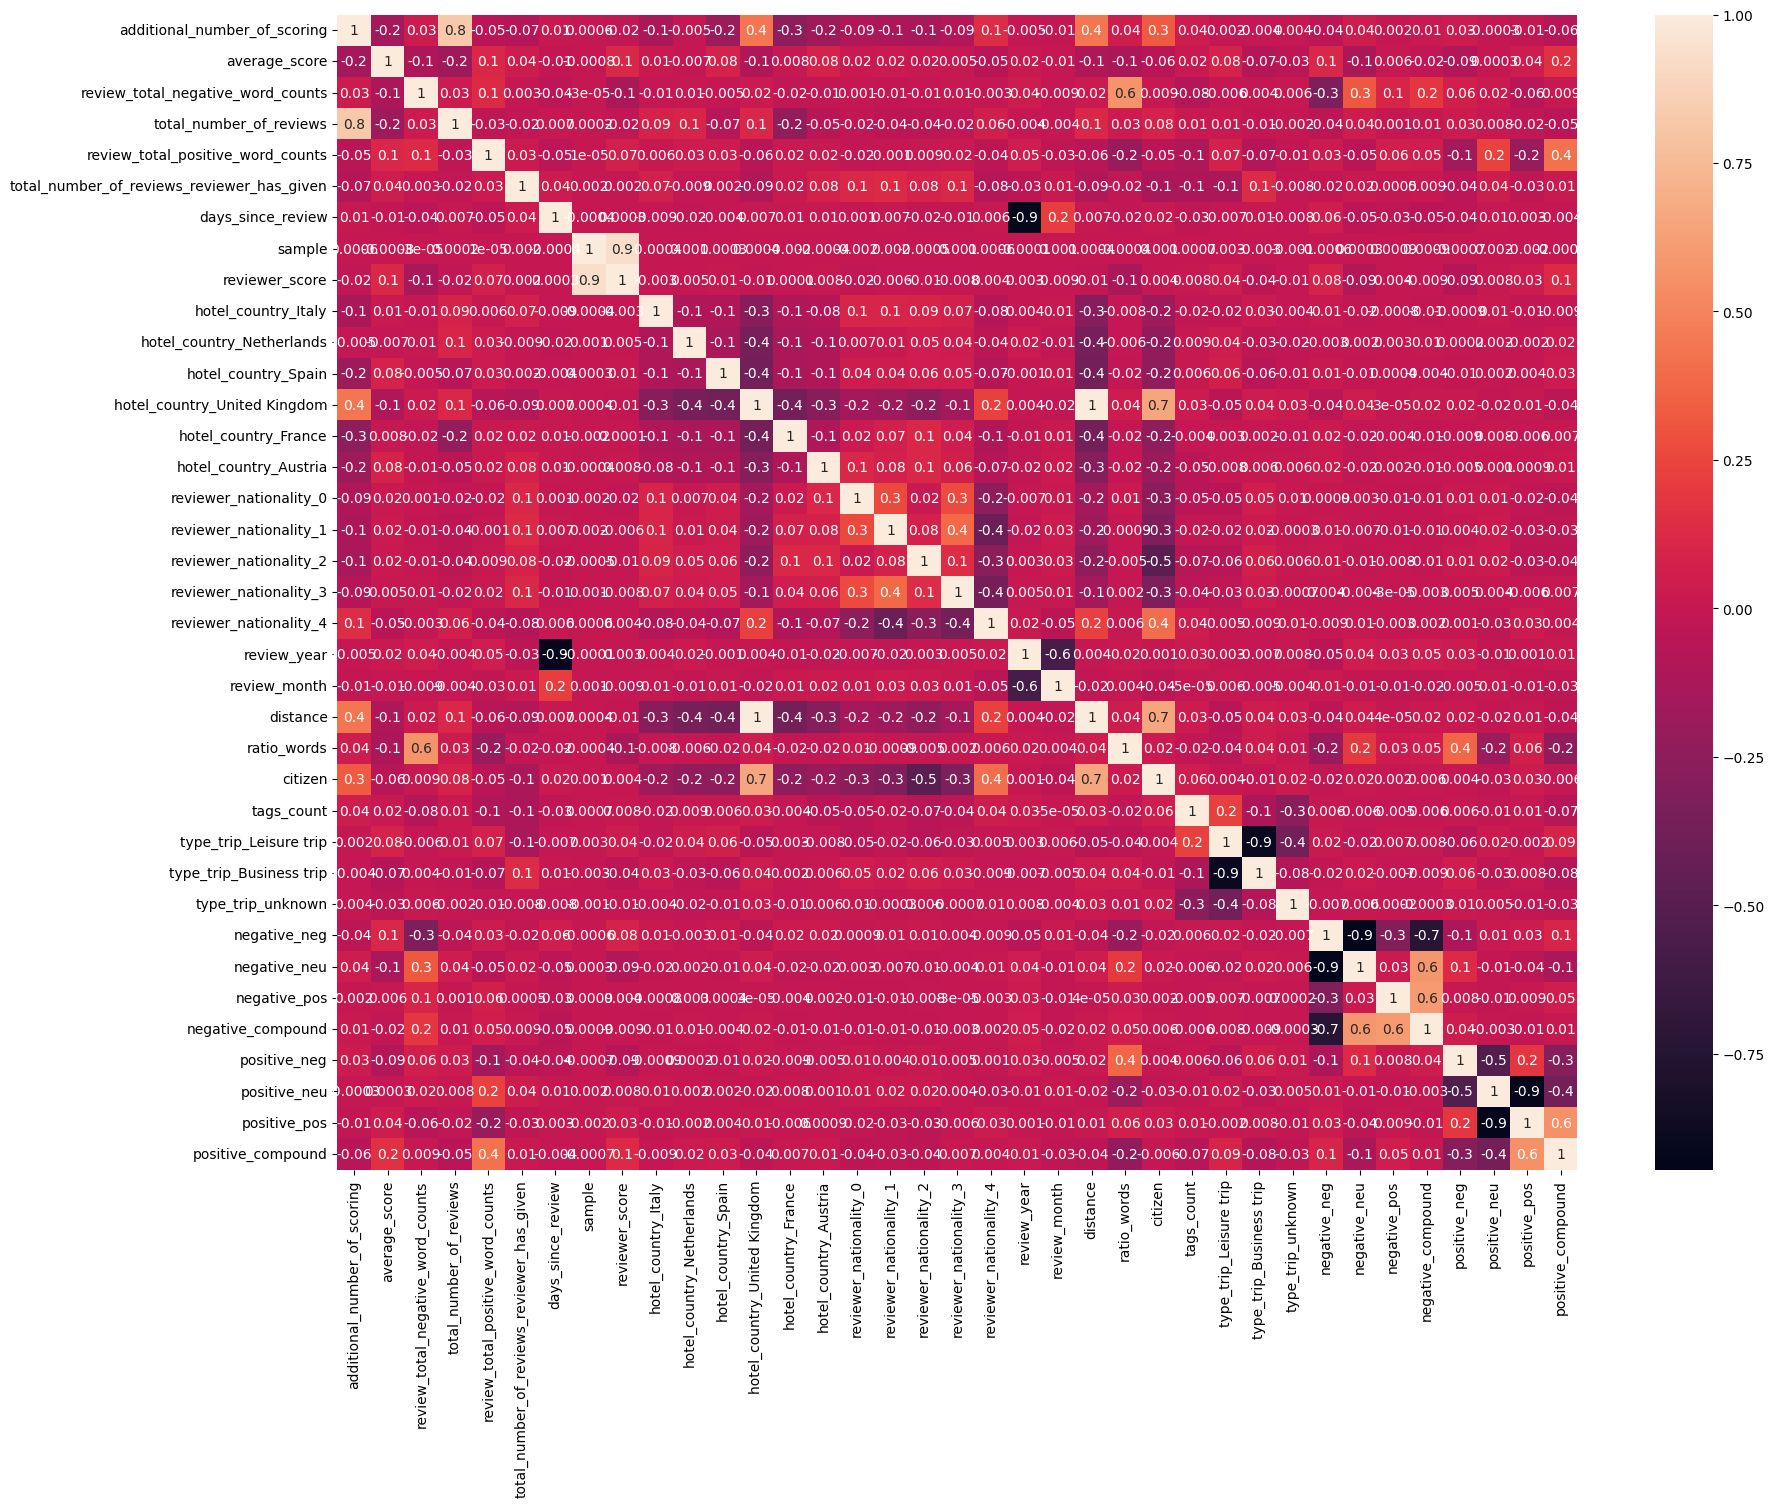

In [113]:
plt.rcParams['figure.figsize'] = (20,15)
sns.heatmap(hotels.corr(), annot=True, fmt='.1g')

Уберем сильно коррелирующие признаки:

In [114]:
hotels.drop(['total_number_of_reviews', 'review_year', 'hotel_country_United Kingdom', 'type_trip_Leisure trip', 'negative_neg', 'positive_pos'], axis = 1, inplace=True)

## <a id='toc1_8_'></a>[Обучение модели](#toc0_)

In [115]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
data = hotels.copy()
# df.drop(object_columns, axis = 1, inplace=True)
data.drop(['review_date'], axis = 1, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 31 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   average_score                               515738 non-null  float64
 2   review_total_negative_word_counts           515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  int64  
 6   sample                                      515738 non-null  int64  
 7   reviewer_score                              515738 non-null  float64
 8   hotel_country_Italy                         515738 non-null  int64  
 9   hotel_country_Netherlands                   515738 non-null  int64  
 

In [116]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
y = train_data.reviewer_score.values           
X = train_data.drop(['reviewer_score'], axis=1)

In [117]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [122]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12546437744922787


Подготовим файл сабмишна на Kaggle

In [123]:
submission = pd.read_csv('submission.csv')
submission.head()

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596


In [125]:
#test_data = test_data.drop(['reviewer_score'], axis=1)
predict_submission = regr.predict(test_data)
submission['reviewer_score'] = predict_submission
submission.to_csv('submission_predict.csv', index=False)